# Bird Flock

In [28]:
# Importamos las clases que se requieren para manejar los agentes (Agent) y su entorno (Model).
# Cada modelo puede contener múltiples agentes.
from mesa import Agent, Model 

# Debido a que necesitamos que existe un solo agente por celda, elegimos ''SingleGrid''.
from mesa.space import SingleGrid

# Con ''SimultaneousActivation, hacemos que todos los agentes se activen ''al mismo tiempo''.
from mesa.time import RandomActivation

# Haremos uso de ''DataCollector'' para obtener información de cada paso de la simulación.
from mesa.datacollection import DataCollector

# matplotlib lo usaremos crear una animación de cada uno de los pasos del modelo.
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation as animation
plt.rcParams["animation.html"] = "jshtml"
matplotlib.rcParams['animation.embed_limit'] = 2**128

# Importamos los siguientes paquetes para el mejor manejo de valores numéricos.
import numpy as np
import pandas as pd

# Definimos otros paquetes que vamos a usar para medir el tiempo de ejecución de nuestro algoritmo.
import time
import datetime

In [29]:
class FlockAgent(Agent):
    def __init__(self, unique_id, model, x, y, width, height):
        super().__init__(unique_id, model)
        self.position = np.array((x, y), dtype=np.float64)
        
        vec = (np.random.rand(2) - 0.5 / 2)
        self.velocity = np.array(vec, dtype=np.float64)
        
        vec = (np.random.rand(2) - 0.5) / 2
        self.acceleration = np.array(vec, dtype = np.float64)
        
        # Magnitud de Aceleración que deben tener para poder integrarse
        self.max_force = 0.3
        
        # Magnitud máxima que puede tener el vector de velocidad
        self.max_speed = 5
        
        # Distancia máxima de visión
        self.perception = 100
        
        self.width = width 
        self.height = height
    
    def step(self):
        self.check_edges()
        self.check_neighbors()
        
        self.position += self.velocity
        self.velocity += self.acceleration
        
        if np.linalg.norm(self.velocity) > 0:
            self.velocity = (self.velocity / np.linalg.norm(self.velocity)) * self.max_speed
        
        self.acceleration = np.array([0,0], dtype = np.float64)
    
    def check_edges(self):
        if self.position.flatten()[0] > self.width:
            self.position[0] = 0
        elif self.positon.flatten()[0] < 0:
            self.position[0] = self.width
        
        if self.position.flatten()[1] > self.height:
            self.position[1] = 0
        
        elif self.position.flatten()[1] < 0:
            self.position[1] = self.height
    
    def check_neighbors(self):
        alignment = self.align()
        cohesion = self.cohesion()
        separation = self.separation()
        
        self.aceleration += alignment + cohesion + separation
            
    def align(self):
        steering = np.array([0,0], dtype=np.float64)
        total = 0
        avg_vector = np.array([0,0], dtype=np.float64)
        for agent in self.model.schedule.agents:
            if np.linalg.norm(agent.position - self.position) < self.perception:
                avg_vector += agent.velocity
                total += 1
        
        if total > 1:
            avg_vector /= total
            avg_vector = (avg_vector / np.linalg.norm(avg_vector)) * self.max_speed
            steering = avg_vector - self.velocity
        
        return steering
    
    def cohesion(self):
        steering = np.array([0,0], dtype= np.float64)
        total = 0
        center_of_mass = np.array([0,0], dtype = np.float64)
        for agent in self.model.schedule.agents:
            if np.linalg.norm(agent.position -self.position) < self.perception:
                center_of_mass += agent.position
                total += 1
            
            if total > 1:
                center_of_mass /= total
                vec_to_com = center_of_mass - self.position
                if np.linalg.norm(vec_to_com) > 0:
                    vec_to_com = (vec_to_com / np.linalg.norm(vec_to_com)) * self.max_speed
                    
                steering = vec_to_com - self.velocity
                if np.linalg.norm(steering) > 0:
                    steering = (steering / np.linalg.norm(steering)) * self.max_force
            
            return steering
    
    def separation(self):
        steering = np.array([0,0], dtype=np.float64)
        total = 0
        avg_vector = np.array([0,0], dtype=np.float64)
        for agent in model.schedule.agents:
            distance = np.linalg.norm(agent.position -self.position)
            if not(np.array_equal(self.position, agent.position)) and distance < self.perception:
                diff = (self.position-agent.position) / distance
                avg_vector = avg_vector + diff
                total += 1
            if total > 0:
                avg_vector /= total
                if np.linalg.norm(avg_vector) > 0:
                    avg_vector = (avg_vector / np.linalg.norm(avg_vector)) * self.max_speed
                steering = avg_vector - self.velocity
                if np.linalg.norm(steering) > self.max_force:
                    steering = (steering / np.linalg.norm(steering))* self.max_force
            return steering
                
        
        
        
        

In [30]:
def get_particles(model):
    result = []
    for agent in model.schedule.agents:
        result.append(agent.position)
    result = np.asarray(result)
    return result

class FlockModel(Model):
    def __init__(self, N, width, height):
        self.num_agents = N
        self.schedule = RandomActivation(self)
        self.datacollector = DataCollector(model_reporters = {"Particles" : get_particles})
        
        # Creando agentes
        for i in range(self.num_agents):
            #unique_id, model, x, y, width, height
            x = np.random.rand() * width
            y = np.random.rand() * height
            a = FlockAgent(i, self, np.random.rand()*1000, np.random.rand() * 1000, width,height)
            self.schedule.add(a)
    def step(self):
        self.datacollector.collect(self)
        self.schedule.step()
    
    

In [31]:
WIDTH = 1000
HEIGHT = 1000
N = 200
MAX_ITERATIONS = 500

# Registramos el tiempo de inicio y ejecutamos la simulación
start_time = time.time()
model = FlockModel(N, WIDTH, HEIGHT)
for i in range(MAX_ITERATIONS):
    model.step()
    
# Imprimimos el tiempo que le tomó correr al modelo
print('Tiempo de ejecución:', str(datetime.timedelta(seconds= (time.time() -start_time))))

AttributeError: 'FlockAgent' object has no attribute 'positon'

ValueError: x and y must be the same size

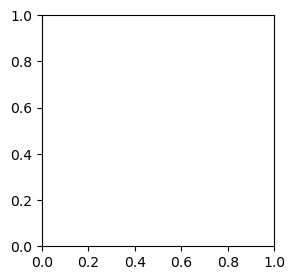

In [27]:
all_positions = model.datacollector.get_model_vars_dataframe()
fig, ax = plt.subplots(figsize =(3,3))
scatter= ax.scatter(all_positions.iloc[0][0][:0], all_positions.iloc[0][0][:1], s=10, edgecolor ="k")
ax.axis([0, WIDTH, 0, HEIGHT])
def animate(i):
    scatter.set_offsets(all_positions.iloc[i][0])
    return scatter

anim = animation.FuncAnimation(fig, animate, frames = MAX_ITERATIONS)
    